In [123]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import pandas as pd
from skimage import metrics
from tqdm import tqdm

In [124]:
data = sio.loadmat(r'Models/FluctuationFixed/Fluctuating/test_processed.mat')
data2 = sio.loadmat(r'Models/BiggerDatasetLargerKernel/Fluctuating/test_processed.mat')
unet = data['recon2']
unet_old = data2['recon2']
smoothed = data['smooth_images']
unsmoothed = data['noisy_images']
ground_truth = data['clean_images']
mask = data['mask']

With ground truth from generation used as the optimal measurement the rest of the metrics are calculated based on that being ground truth

In [125]:
df = pd.DataFrame(columns=['unet_mse', 'unet_ssim', 'smoothed_mse', 'smoothed_ssim', 'unsmoothed_mse', 'unsmoothed_ssim', 'unet_old_mse', 'unet_old_ssim'])
df

,unet_mse,unet_ssim,smoothed_mse,smoothed_ssim,unsmoothed_mse,unsmoothed_ssim,unet_old_mse,unet_old_ssim


In [161]:
def mse(input, target):
    """
    returns the array of the mean squared error of the input vs target
    :param input: array
    :param target: array
    :return: 
    """
    return np.sum(np.subtract(input, target) ** 2, axis=tuple([0, 1, 2]))

def ssim(input, target):
    """
    return the array of SSIM of the input vs target
    :param input: 
    :param target: 
    :return: 
    """
    ssim = []
    for i in range(input.shape[-1]):
        ssim.append(metrics.structural_similarity(target[:,:,:,i],input[:,:,:,i], gaussian_weights=True, sigma=1.5, use_sample_covariance=False))
    return np.array(ssim)

In [162]:
for i in tqdm(range(ground_truth.shape[-1])):
        smoothed[...,i] = smoothed[...,i] * mask
        unsmoothed[...,i] = unsmoothed[...,i] * mask
        unet[...,i] = unet[...,i] * mask
        unet_old[...,i] = unet_old[...,i] * mask

100%|██████████| 756/756 [00:09<00:00, 75.95it/s] 


In [163]:
df['smoothed_mse'] = mse(smoothed, ground_truth) 
df['smoothed_ssim'] = ssim(smoothed, ground_truth)
df['unsmoothed_mse'] = mse(unsmoothed, ground_truth)
df['unsmoothed_ssim'] = ssim(unsmoothed, ground_truth)
df['unet_mse'] = mse(unet, ground_truth)
df['unet_ssim'] = ssim(unet, ground_truth)
df['unet_old_mse'] = mse(unet_old, ground_truth)
df['unet_old_ssim'] = ssim(unet_old, ground_truth)

<ipython-input-161-7cee15128532>:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim.append(metrics.structural_similarity(target[:,:,:,i],input[:,:,:,i], gaussian_weights=True, sigma=1.5, use_sample_covariance=False))


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   unet_mse         756 non-null    float64
 1   unet_ssim        756 non-null    float64
 2   smoothed_mse     756 non-null    float64
 3   smoothed_ssim    756 non-null    float64
 4   unsmoothed_mse   756 non-null    float64
 5   unsmoothed_ssim  756 non-null    float64
 6   unet_old_mse     756 non-null    float64
 7   unet_old_ssim    756 non-null    float64
dtypes: float64(8)
memory usage: 47.4 KB


In [165]:
df.head()

,unet_mse,unet_ssim,smoothed_mse,smoothed_ssim,unsmoothed_mse,unsmoothed_ssim,unet_old_mse,unet_old_ssim
0,35996.011207,0.360943,163558.216590,0.337839,273444.478176,0.203685,40131.033538,0.463192
1,26577.999158,0.419935,162028.846702,0.325578,185302.041025,0.245659,29519.014158,0.535877
2,30915.872966,0.384335,157378.745824,0.337520,209762.424963,0.215980,40512.935281,0.492920
3,23952.480795,0.370460,158298.567836,0.313579,267924.073460,0.202808,61427.049086,0.456937
4,22236.420452,0.438181,150164.812018,0.371518,150602.652911,0.259950,23770.523447,0.570864


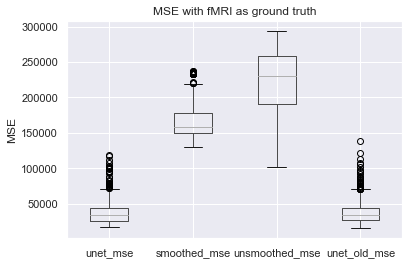

In [166]:
plt.figure()
df.boxplot(column=['unet_mse', 'smoothed_mse', 'unsmoothed_mse', 'unet_old_mse'])
plt.ylabel('MSE')
plt.title('MSE with fMRI as ground truth')
plt.show()

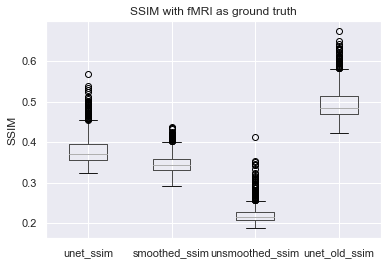

In [167]:
plt.figure()
df.boxplot(column=['unet_ssim', 'smoothed_ssim', 'unsmoothed_ssim', 'unet_old_ssim'])
plt.ylabel('SSIM')
plt.title('SSIM with fMRI as ground truth')
plt.show()

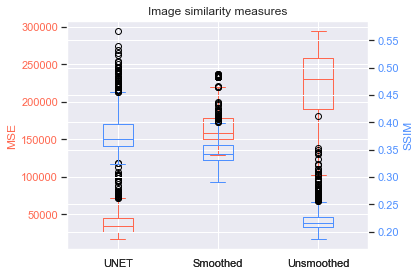

In [168]:
fig, ax1 = plt.subplots()

colour1 = '#FF674F'
ax1.set_title('Image similarity measures')
#ax1.set_xlabel('MSE')
df.boxplot(column=['unet_mse', 'smoothed_mse', 'unsmoothed_mse'], color=colour1)
ax1.tick_params(axis='y', labelcolor=colour1)
ax1.set_ylabel('MSE', color=colour1)

ax2 = ax1.twinx()
colour2 = '#4F90FF'
df.boxplot(column=['unet_ssim', 'smoothed_ssim', 'unsmoothed_ssim'], color=colour2)
ax2.set_ylabel('SSIM', color=colour2)
ax2.tick_params(axis='y', labelcolor=colour2)
ax2.set_xticklabels(['','','', 'UNET', 'Smoothed', 'Unsmoothed'])
fig.tight_layout()
plt.savefig('Image Similarity Measures.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [169]:
images_per_OP = 36
optical_property_changes = np.arange(-int(len(df)/(images_per_OP*2)), int(len(df)/(images_per_OP*2))+1)

In [179]:
df2 = pd.DataFrame(columns=['OPchange', 'MSE', 'ReconstructionMethod'])
recon_method = ['unet_mse', 'smoothed_mse', 'unsmoothed_mse', 'unet_old_mse']
for recon in recon_method:
    for [i, x] in enumerate(optical_property_changes):
        df3 = pd.DataFrame({'OPchange' : x*np.ones(images_per_OP), 'MSE' : df[recon][i*images_per_OP:images_per_OP*(1+i)], 'ReconstructionMethod' : [recon]*images_per_OP})
        df2 = pd.concat([df2, df3])

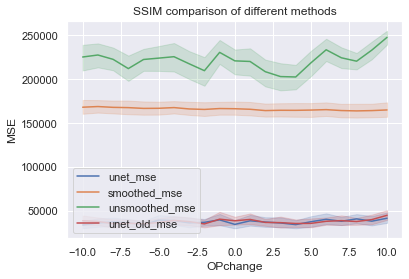

In [180]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="OPchange", y="MSE",
             hue="ReconstructionMethod",
             data=df2)
plt.title('MSE comparison of different methods')
plt.legend(loc='middle left')
plt.savefig('PostprocessingComparisonMSE.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [181]:
df2 = pd.DataFrame(columns=['OPchange', 'MSE', 'ReconstructionMethod'])
recon_method = ['unet_ssim', 'smoothed_ssim', 'unsmoothed_ssim', 'unet_old_ssim']
for recon in recon_method:
    for [i, x] in enumerate(optical_property_changes):
        df3 = pd.DataFrame({'OPchange' : x*np.ones(images_per_OP), 'SSIM' : df[recon][i*images_per_OP:images_per_OP*(1+i)], 'ReconstructionMethod' : [recon]*images_per_OP})
        df2 = pd.concat([df2, df3])

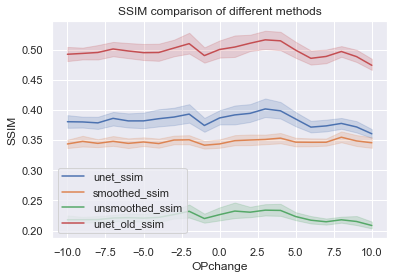

In [182]:
sns.lineplot(x="OPchange", y="SSIM",
             hue="ReconstructionMethod",
             data=df2)
plt.legend(loc='lower left')
plt.title('SSIM comparison of different methods')
plt.savefig('PostprocessingComparisonSSIM.pdf', bbox_inches='tight', dpi=300)
plt.show()